# Introduction to Monte Carlo Methods in Reinforcement Learning

Monte Carlo (MC) methods are a class of computational algorithms that rely on repeated random sampling to obtain numerical results. In the context of reinforcement learning, Monte Carlo methods can be used to estimate value functions and derive policies based on the experiences sampled from the environment. Unlike dynamic programming, Monte Carlo methods do not require a complete model of the environment and can be used in model-free settings.

## Monte Carlo Prediction
We begin by considering Monte Carlo methods for learning the state-value function for a given policy. Recall that the value of a state is the expected return—expected cumulative future discounted reward—starting from that state. An obvious way to estimate it from experience, then, is simply to average the returns observed after visits to that state. As more returns are observed, the average should converge to the expected value. This idea underlies all Monte Carlo methods.

**Goal.** Estimate $v_{\pi}(s)$, the value of a state $s$ under policy $\pi$, given a set of episodes obtained by following the policy $\pi$ and passing through $s$ (each occurrence of state $s$ in an episode is called a visit to $s$). 

* The *first-visit MC method* estimates $v_{\pi}(s)$ as the average of the returns following first visits to $s$. 
* The *every-visit MC method* averages the returns following all visits to $s$.

In this notebook we focus on the first-visit MC method for estimating $v_{\pi}(s)$. A simple algorithm called *first-visit MC* is given below:

<img src="images/first-visit-monte-carlo.png" width="1300" height="480" >

In the following code cell we implement this algorithm. 

----

In [1]:
import numpy as np
from custom_classes import RandomPolicy

def generate_episode(env, policy):
    episode = []

    # Generate an episode using the given policy.
    state = env.reset()
    action = policy(state)
    next_state, reward, terminated  = env.step(action)
    episode.append((state, action, reward))

    while not terminated:
        state = next_state
        action = policy(state)
        next_state, reward, terminated = env.step(action)
        episode.append((state, action, reward))

    return episode

def first_visit_monte_carlo(env, policy, gamma=1.0, num_episodes=5_000):
    # Initialize the value of each state to be a random real number.
    V = {state: np.random.rand() for state in env.state_space}

    # Initialize the Reward variable with empty lists for each state.
    returns = {state: [] for state in env.state_space}

    for _ in range(num_episodes):
        # Generate an episode using the given policy.
        episode = generate_episode(env, policy)

        # Initialize the expected return.
        G = 0.0

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma*G + reward

            # If state is not in the episode[:t], then it is the first visit.
            if state not in [x[0] for x in episode[:t]]:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
    return V


-----

### Example 5.1: Blackjack 

The object of the popular casino card game of blackjack is to
obtain cards the sum of whose numerical values is as great as possible without exceeding
21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider
the version in which each player competes independently against the dealer. The game
begins with two cards dealt to both dealer and player. One of the dealer’s cards is face
up and the other is face down. If the player has 21 immediately (an ace and a 10-card),
it is called a natural. He then wins unless the dealer also has a natural, in which case the
game is a draw. If the player does not have a natural, then he can request additional
cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes
bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks
according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and
hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win,
lose, or draw—is determined by whose final sum is closer to 21.


The following code cell applies the first-visit MC prediction algorithm on a custom blackjack environment 
for a random policy. Please see `Monte-Carlo-Methods/custom_classes.py` for the `CustomBlackJack` code. 



-----

In [2]:
from custom_classes import CustomBlackjackEnv

env = CustomBlackjackEnv()

# Compute the value function for the random policy.
V = first_visit_monte_carlo(env, RandomPolicy(env), num_episodes=5_000)

# Print the value function for the random policy.
print("--------------- Value Function for Random Policy ----------------")
i = 0
for state, value in V.items():
    if i < 10:
        print(f"V[{state}] = {V[state]}")
    else:
        break
    i += 1

--------------- Value Function for Random Policy ----------------
V[(4, 1, False)] = -1.0
V[(4, 1, True)] = 0.1328736353486648
V[(4, 2, False)] = -1.0
V[(4, 2, True)] = 0.09996613362184337
V[(4, 3, False)] = 0.4890083815160391
V[(4, 3, True)] = 0.3046629649961443
V[(4, 4, False)] = -1.0
V[(4, 4, True)] = 0.7866178100802815
V[(4, 5, False)] = -1.0
V[(4, 5, True)] = 0.5086108191377495


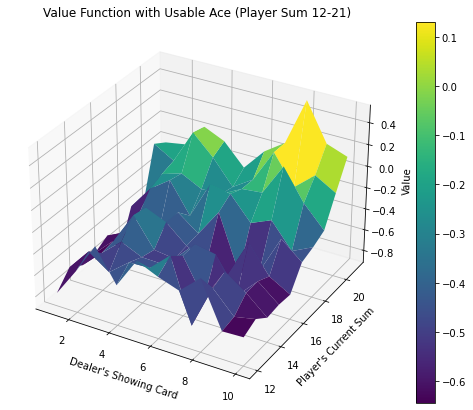

In [3]:
from mc_utils import plot_value_function
# Plot for states without a usable ace, with axes switched
plot_value_function(V, 0, 'Value Function with Usable Ace (Player Sum 12-21)')

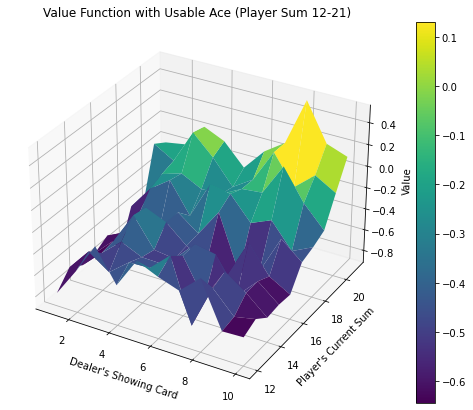

In [4]:
# Plot for states with a usable ace, with axes switched
plot_value_function(V, 0, 'Value Function with Usable Ace (Player Sum 12-21)')

----


Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits. To find the state-value function for this policy by a Monte Carlo approach, one simulates many blackjack games using the policy and averages the returns following each state.



The following code cell evaluates this policy with 500,000 games (the estimates for states with a usable ace are less certain and less regular because these
states are less common). 

----

In [5]:
from custom_classes import DeterministicPolicy
# Sutton & Barto BlackJack policy from the Monte Carlo Chapter.
# sab_policy = {state: int(state[0] < 20) for state in env.state_space}
sab_policy_mapping = {state : int(state[0] < 20) for state in env.state_space}
sab_policy = DeterministicPolicy(env, sab_policy_mapping)

# Compute the value function for the Sutton & Barto policy with 500_000 iterations.
# Note, this will take a few minutes..... Using Chapter 2 for inspiration, can you make this faster?
V = first_visit_monte_carlo(env, sab_policy, num_episodes=500_000)


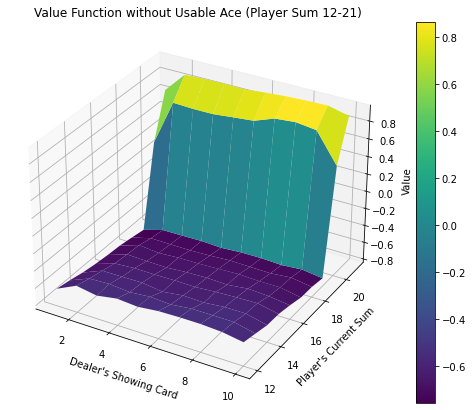

In [6]:
# Plot for states without a usable ace.
plot_value_function(V, 0, 'Value Function without Usable Ace (Player Sum 12-21)')

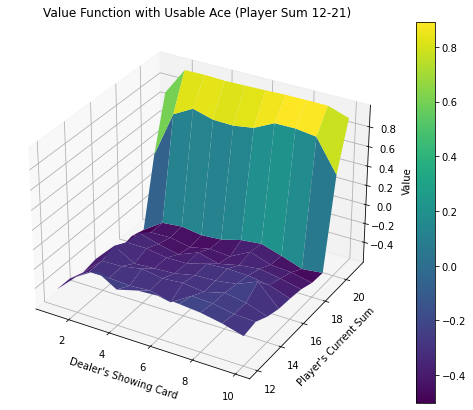

In [7]:
# Plot for states with a usable ace.
plot_value_function(V, 1, 'Value Function with Usable Ace (Player Sum 12-21)')

In [8]:
def first_visit_monte_carlo_better(env, policy, gamma=1.0, alpha=0.025, num_episodes=5_000):
    # Initialize the value function randomly.
    V = {state: 0.0 for state in env.state_space}

    N = {state: 0 for state in env.state_space}

    for _ in range(num_episodes):
        episode = []

        # Generate an episode using the given policy.
        state = env.reset()
        action = policy(state)
        next_state, reward, terminated  = env.step(action)
        episode.append((state, action, reward))
        while not terminated:
            state = next_state
            action = policy(state)
            next_state, reward, terminated = env.step(action)
            episode.append((state, action, reward))


        # Initialize the expected return.
        G = 0.0

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma*G + reward
            if state not in [x[0] for x in episode[:t]]:
                N[state] += 1
                V[state] = V[state] + (1/N[state])*(G - V[state]) # Incremental Mean
    return V

In [9]:
V = first_visit_monte_carlo_better(env, sab_policy, num_episodes=500_000)

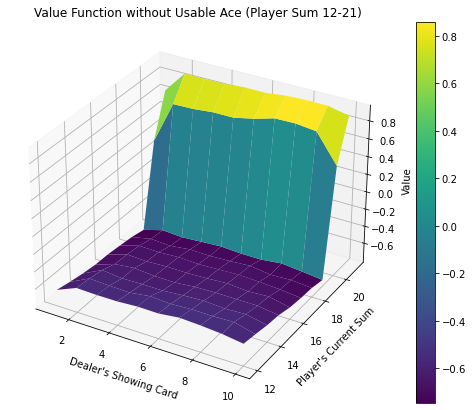

In [10]:
# Plot for states without a usable ace.
plot_value_function(V, 0, 'Value Function without Usable Ace (Player Sum 12-21)')

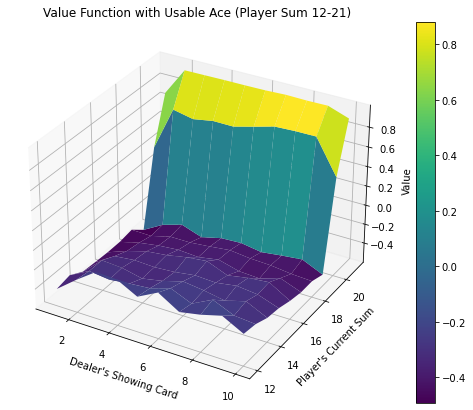

In [11]:
# Plot for states with a usable ace.
plot_value_function(V, 1, 'Value Function with Usable Ace (Player Sum 12-21)')